# Prototype Model

Looking back at the feasibility file, the initial model failed to learn patterns from the data. To address this, I plan to unfreeze an additional layer on the GPT-2 model alongside the existing classification layer. I will then extract the embeddings and use these as features in a logistic regression model. The logistic regression model should then be able to predict the labels of the test set, ideally, with an accuracy greater than 50%.

# Preprocessing

In [1]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from google.colab import drive
from datasets import Dataset
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

Mounted at /content/drive


In [14]:
# Load in the data
path = "/content/drive/MyDrive/Colab Notebooks/LLM Project/data.csv"
df = pd.read_csv(path)
df.head()

,text,labels
0,Flesh craves flesh lingering want\nSkin plaste...,1
1,How does it feel\nTo glide across the diamond ...,1
2,Your wires wrapped around my beating heart\nUn...,1
3,"Oh, you're finally here\nTake me, take me away...",1
4,I dreamed a dream so beautiful it blinded my e...,1


In [15]:
# Function that preprocesses the CSV file and prepares the sets for training
def preprocess(df, shuffle=True):
  # Shuffle the data entries if when making the dataset you didn't mix up the entries like me
  if shuffle:
    df = df.sample(frac=1).reset_index(drop=True)

  # Convert the place holder \n characters into actual line breaks
  print("Before conversion:")
  print(df['text'][0])

  df['text'] = df['text'].apply(lambda x: x.replace("\\n", "\n"))

  # Check to see if conversion worked
  print("\nAfter conversion:")
  print(df['text'][0])

  # Split the data into training and test sets
  test_df = df.sample(frac=0.2, random_state=42)
  train_df = df.drop(test_df.index)

  # Check to see if the shapes are correct
  print("\nDataframe sizes:", test_df.shape, train_df.shape)

  # Convert the CSV files into Hugging Face Datasets for training
  train_dataset = Dataset.from_pandas(train_df).remove_columns(["__index_level_0__"])
  test_dataset = Dataset.from_pandas(test_df).remove_columns(["__index_level_0__"])

  print("\n")
  print(train_dataset)
  print(test_dataset)

  return test_df, train_df, train_dataset, test_dataset

In [16]:
test_df, train_df, train_dataset, test_dataset = preprocess(df, shuffle=True)

Before conversion:
as a child my mother once found me scraping my\nshadow from the pavement\nhe'll be my best friend - she said to me\nin the dark when the creatures emerge he has long\nabandoned me

After conversion:
as a child my mother once found me scraping my
shadow from the pavement
he'll be my best friend - she said to me
in the dark when the creatures emerge he has long
abandoned me

Dataframe sizes: (6, 2) (24, 2)


Dataset({
    features: ['text', 'labels'],
    num_rows: 24
})
Dataset({
    features: ['text', 'labels'],
    num_rows: 6
})


In [17]:
test_df

,text,labels
27,Trapped in the water everything seems clear no...,1
15,"I tried and tried, and bled.\nI failed despite...",0
23,"under the willow, under the willow I go. my tr...",0
17,Your wires wrapped around my beating heart\nUn...,1
8,"The city calls my name\nBut so do you, so I'll...",1
9,Flesh craves flesh lingering want\nSkin plaste...,1


In [18]:
train_df.head()

,text,labels
0,as a child my mother once found me scraping my...,0
1,"A raw, thumping ache is for sure\nTo find prob...",0
2,But I know the waltz with you\nI've never been...,0
3,You can love your family deeply\nand still car...,0
4,True love watches the city skyline\nAdmiring f...,1


In [19]:
# Function that tokenizes the plain text datasets for training
def tokenize_text(train_dataset, test_dataset):
    # Load in tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    # Tokenize the data
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    # Apply the tokenization
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Format datasets for PyTorch
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    return train_dataset, test_dataset

In [20]:
train_dataset, test_dataset = tokenize_text(train_dataset, test_dataset)

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

# Training GPT-2

Now, to unfreeze one layer of the model and the classification head for training. I'll also be changing the training arguments slightly.

In [21]:
# Load in pre-trained GPT-2 model with a classification head
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)

# Set padding token
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model.config.pad_token_id = tokenizer.eos_token_id

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classification head
for param in model.score.parameters():
    param.requires_grad = True

# Unfreeze the last layer
for param in model.transformer.h[-1:].parameters():
    param.requires_grad = True

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=5e-5, # Increasing learning rate to 5e-5 to also address the slow learning
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.727500,3.103934
2,1.955700,2.901507
3,2.418800,2.539908
4,1.374500,2.253194
5,1.798700,2.004104
6,1.482900,1.825315
7,1.047000,1.706287
8,0.743300,1.607643
9,0.790200,1.564495
10,0.791100,1.552254


('./protoype_model/tokenizer_config.json',
 './protoype_model/special_tokens_map.json',
 './protoype_model/vocab.json',
 './protoype_model/merges.txt',
 './protoype_model/added_tokens.json')

In [27]:
# Save the trained model and tokenizer for feature extraction
model.save_pretrained("./prototype_model")
tokenizer.save_pretrained("./prototype_model")

('./prototype_model/tokenizer_config.json',
 './prototype_model/special_tokens_map.json',
 './prototype_model/vocab.json',
 './prototype_model/merges.txt',
 './prototype_model/added_tokens.json')

In [29]:
# Check to see the directory containing the model is there
!ls

drive  prototype_model	results  sample_data


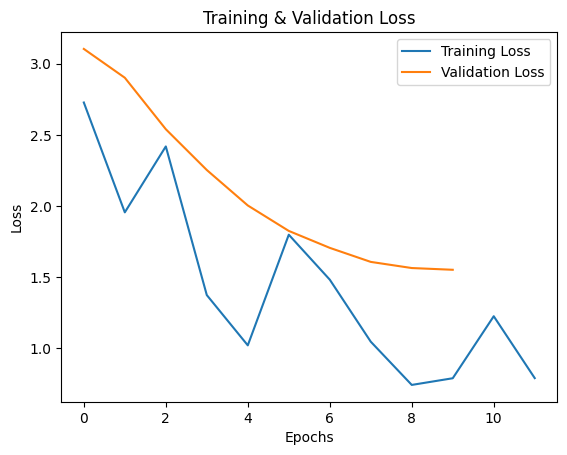

In [30]:
# Extract losses
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss  = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Plot the training and validation loss
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Extract Embeddings and Logistic Regression

Now, I'll feed the now fine-tuned model the validation and training dataframes and extract the embeddings. These will then be given to a logistic regression model and evaluated.

In [25]:
# Function that feeds the whole dataframe into the fine tuned model and collects the embeddings
def get_embeddings(df, batch_size=8, model_path=None):

    # Load model and tokenizer
    model = GPT2ForSequenceClassification.from_pretrained(model_path)
    tokenizer = GPT2Tokenizer.from_pretrained(model_path)
    tokenizer.pad_token = tokenizer.eos_token

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    texts = df["text"].tolist()
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size)):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model.transformer(**inputs)
            last_hidden_state = outputs.last_hidden_state

            pooled = last_hidden_state.mean(dim=1)

            embeddings.append(pooled.cpu().numpy())

    embeddings_np = np.vstack(embeddings)

    return embeddings_np

In [31]:
val_embeddings = get_embeddings(test_df, batch_size=8, model_path="./prototype_model")
train_embeddings = get_embeddings(train_df, batch_size=8, model_path="./prototype_model")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

To ensure that the GPT-2 embeddings are doing most of the work during inference, I'm keeping the logisitc regression model as simple as possible. Only scaling the embeddings, setting the random_state to 42, and increasing the max iterations to avoid a ConvergenceWarning.

Accuracy: 0.67


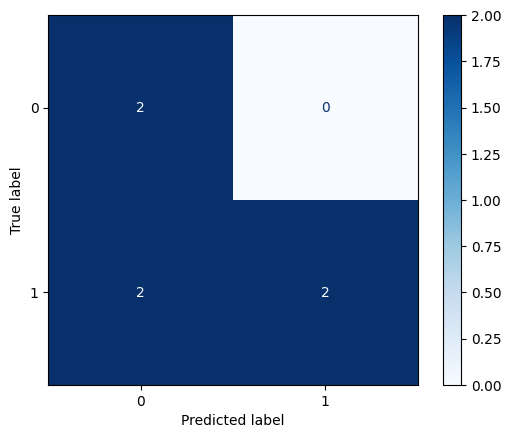

In [33]:
# Split the data and scale the embeddings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(train_embeddings)
X_val_scaled = scaler.transform(val_embeddings)

y_true = test_df["labels"].values
y_train = train_df['labels'].values

# Initialize and train the model
lr = LogisticRegression(max_iter=1000, random_state=42)  # mostly default parameters
lr.fit(X_train_scaled, y_train)

# Run predictions
y_pred = lr.predict(X_val_scaled)
y_true = test_df["labels"]

# Calculate metrics and display the confusion matrix
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

cm = confusion_matrix(y_true, y_pred, labels=lr.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=lr.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

The logistic regression model was able to classify 4/6 poem correctly, which is excellent that we're already better than a random guess using such little data. Although, the model does seem to struggle to pick up on my writing style with it mislabeling 50% of my poems as not mine.